In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.calibration import calibration_curve
from lifelines.utils import concordance_index

In [7]:
import pandas as pd
import numpy as np
import os, psutil
import copy
import matplotlib.pyplot as plt
from ast import literal_eval
from datetime import datetime, timedelta

import pickle
import awswrangler as wr
import boto3
import gc
import math
import pyarrow.parquet as pq
pd.set_option('display.max_columns', None)

from tqdm import tqdm

tqdm.pandas()

## Preprocessing

In [8]:
df = pd.read_csv('cohort_12-04_selected.csv')
pd.set_option('display.max_columns', None)

/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
columns = set(df.columns) - {"MA_NUM", "HCPCS_CD", "CLAIM_FROM_DT", "ICD9_CD", "ICD9_DT", 
                              "DISCHARG_DT", "POLICY_START_DT", "POLICY_END_DT", "DOB_DT",
                              "LNGCD_RF", "AIDCT_RF", "Source", 'Start_dt', 'End_dt', 'Overdose_Death', "Race", "Outcome_Abuse_3months", "Outcome_Abuse_3months",
                              "Outcome_Abuse_6months", "Outcome_Abuse_12months", "Outcome_Overdose_3months",
                              "Outcome_Overdose_6months", "Outcome_Overdose_12months", "Outcome_Overdose_12months",
                              "Outcome_3months", "Outcome_12months", "ZIP", "ZCTA5", "FIPS", "Main_Provider", 'Continuously_Enrolled_12months'}

columns = [x for x in df.columns if x in columns]

df = df[columns]

columns = [x for x in columns if x!='State']
df =df[columns]

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for f in ['GENCD_RF', 'Surgery_type']:
    le = LabelEncoder()
    le.fit(df[f])
    label_encoders[f] = le.classes_
    df[f+'_enc'] = le.transform(df[f])
    
df.drop(columns = ['GENCD_RF', 'Surgery_type', 'SURG_DT'], inplace = True)

In [11]:
dummies = pd.get_dummies(df['Surgery_type_enc'], prefix='Surgery')
df[dummies.columns] = dummies

In [12]:
new_columns = [x for x in df.columns if (x != 'Surgery_type_enc')]
RF_columns = new_columns
LR_columns = RF_columns

In [13]:
df_train, df_test = train_test_split(df[new_columns], test_size = 0.1, stratify = df['Outcome_6months'], random_state = 1)

X_train, y_train = df_train.drop(columns = ['Outcome_6months']), df_train['Outcome_6months']
X_test, y_test = df_test.drop(columns = ['Outcome_6months']), df_test['Outcome_6months']

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
over = RandomOverSampler(sampling_strategy=0.3, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.7, random_state = 1)

X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

## Vulnerable status

In [15]:
master_df = pd.read_csv('cohort_12-04.csv')

/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
obesity_codes = ['END009']
diabetes_codes = ['PRG019'] + ['END00{}'.format(i) for i in range(2,7)]
depression_codes = ['MBD002']

In [17]:
master_df['obesity'] = (master_df[['Diag_'+c for c in obesity_codes]].sum(axis = 1) > 0).astype(int)
master_df['diabetes'] = (master_df[['Diag_'+c for c in diabetes_codes]].sum(axis = 1) > 0).astype(int)
master_df['depression'] = (master_df[['Diag_'+c for c in depression_codes]].sum(axis = 1) > 0).astype(int)

## Helper functions

In [18]:
def get_calibration_data(y, y_pred, B = 100, n_bins = 10, random_state = 1):
    
    np.random.seed(random_state)
    prob_trues = np.zeros((B,n_bins))
    prob_preds = np.zeros((B,n_bins))
    for b in tqdm(range(B)):
        bootstrap_idxs = sorted(list(np.random.choice(range(len(y)), size = len(y))))
        y_bootstrap, y_pred_bootstrap = np.array([y.iloc[i] for i in bootstrap_idxs]), np.array([y_pred[i] for i in bootstrap_idxs])
        prob_true, prob_pred = calibration_curve(y_bootstrap, y_pred_bootstrap, n_bins = n_bins)
        try:
            prob_trues[b,:] = prob_true
            prob_preds[b,:] = prob_pred
        except:
            prob_trues[b,:] = np.nan
            prob_preds[b,:] = np.nan
        
    prob_errors = np.nanstd(prob_trues,axis = 0)
    prob_true = np.nanmean(prob_trues, axis = 0)
    prob_pred = np.nanmean(prob_preds, axis = 0)
    
    lr_probas = LinearRegression()
    lr_probas.fit(prob_pred.reshape(-1,1), prob_true)
    prob_true_reg = lr_probas.predict(prob_pred.reshape(-1,1))
    
    return prob_true, prob_pred, prob_true_reg, prob_errors, lr_probas
    

## Train model

In [19]:
rf = RandomForestClassifier(max_depth = 20, n_estimators = 200,random_state = 1)
rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_test)[:,1]

In [20]:
temp_df = pd.concat([pd.DataFrame(y_test.values), pd.DataFrame(y_pred_proba)], axis = 1)
temp_df.index = y_test.index
temp_df.columns = ['y', 'y_pred']

### Depression

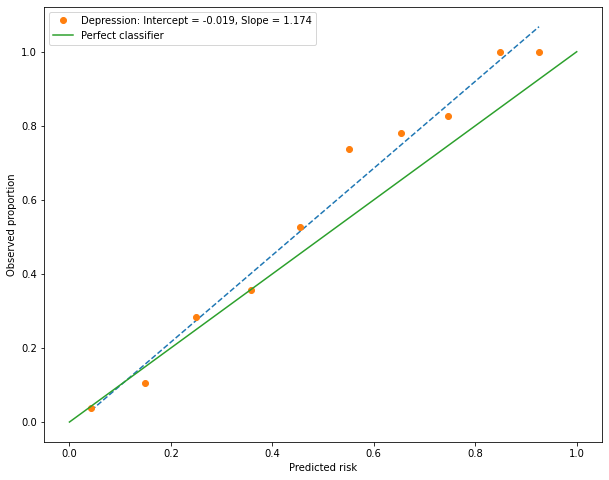

In [24]:
y_dep = temp_df.loc[master_df.depression == 1].y
y_dep_pred = temp_df.loc[master_df.depression == 1].y_pred.values


prob_true, prob_pred = calibration_curve(y_dep, y_dep_pred, n_bins = 10)

lr_probas = LinearRegression()
lr_probas.fit(prob_pred.reshape(-1,1), prob_true)
prob_true_reg = lr_probas.predict(prob_pred.reshape(-1,1))

plt.figure(figsize = (10,8))
plt.plot(prob_pred, prob_true_reg, linestyle = '--') 
plt.plot(prob_pred, prob_true, linestyle = ' ', marker = 'o',
         label = 'Depression: Intercept = {:.3f}, Slope = {:.3f}'.format(lr_probas.intercept_, lr_probas.coef_[0]))
plt.xlabel('Predicted risk')
plt.ylabel('Observed proportion')

plt.plot([0,1], [0,1], label = 'Perfect classifier')
plt.legend(loc='best')
plt.savefig('calibration_depression.svg')
plt.show()


### Diabetes

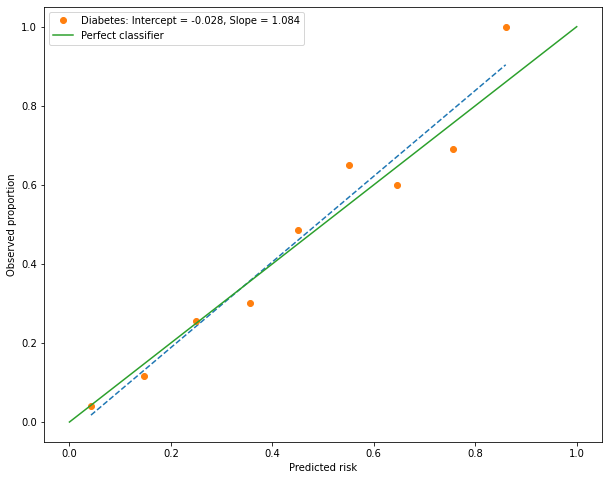

In [27]:
y_diab = temp_df.loc[master_df.diabetes == 1].y
y_diab_pred = temp_df.loc[master_df.diabetes == 1].y_pred.values


prob_true, prob_pred = calibration_curve(y_diab, y_diab_pred, n_bins = 10)

lr_probas = LinearRegression()
lr_probas.fit(prob_pred.reshape(-1,1), prob_true)
prob_true_reg = lr_probas.predict(prob_pred.reshape(-1,1))

plt.figure(figsize = (10,8))
plt.plot(prob_pred, prob_true_reg, linestyle = '--') 
plt.plot(prob_pred, prob_true, linestyle = ' ', marker = 'o',
         label = 'Diabetes: Intercept = {:.3f}, Slope = {:.3f}'.format(lr_probas.intercept_, lr_probas.coef_[0]))
plt.xlabel('Predicted risk')
plt.ylabel('Observed proportion')

plt.plot([0,1], [0,1], label = 'Perfect classifier')
plt.legend(loc='best')
plt.savefig('calibration_diabetes.svg')
plt.show()


### Obesity

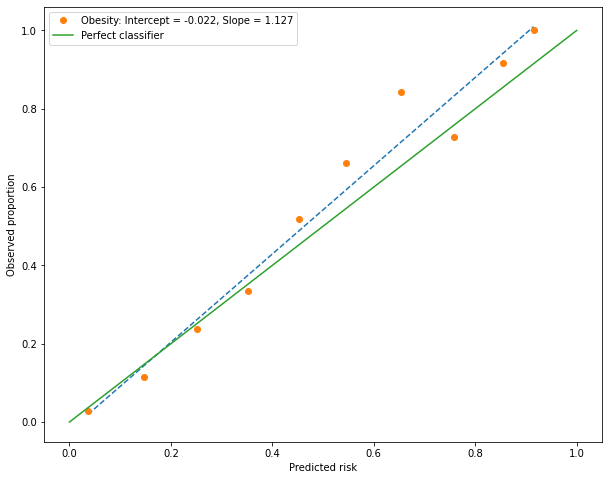

In [29]:
y_ob = temp_df.loc[master_df.obesity == 1].y
y_ob_pred = temp_df.loc[master_df.obesity == 1].y_pred.values

prob_true, prob_pred = calibration_curve(y_ob, y_ob_pred, n_bins = 10)

lr_probas = LinearRegression()
lr_probas.fit(prob_pred.reshape(-1,1), prob_true)
prob_true_reg = lr_probas.predict(prob_pred.reshape(-1,1))

plt.figure(figsize = (10,8))
plt.plot(prob_pred, prob_true_reg, linestyle = '--')
plt.plot(prob_pred, prob_true, linestyle = ' ', marker = 'o', 
         label = 'Obesity: Intercept = {:.3f}, Slope = {:.3f}'.format(lr_probas.intercept_, lr_probas.coef_[0]))
plt.xlabel('Predicted risk')
plt.ylabel('Observed proportion')

plt.plot([0,1], [0,1], label = 'Perfect classifier')
plt.legend(loc='best')
plt.savefig('calibration_obesity.svg')
plt.show()

## Final plot

100%|██████████| 100/100 [00:10<00:00,  9.71it/s]


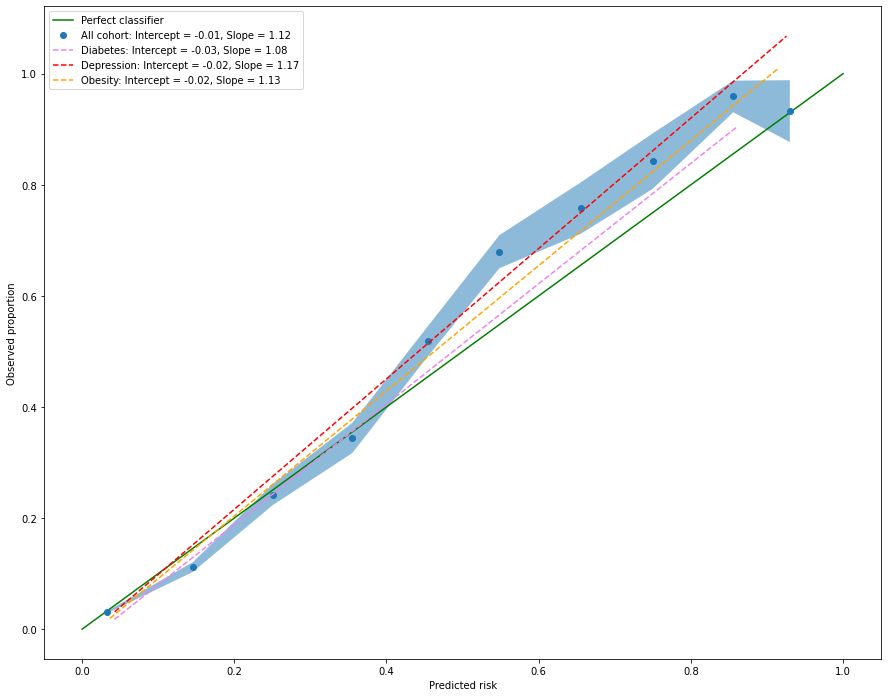

In [31]:
prob_true, prob_pred, prob_true_reg, prob_errors, lr_probas = get_calibration_data(y_test, y_pred_proba, random_state = 1)

plt.figure(figsize = (15,12))
plt.plot([0,1], [0,1], color = 'green', label = 'Perfect classifier')
plt.plot(prob_pred, prob_true, linestyle = ' ', marker = 'o', 
         label = 'All cohort: Intercept = {:.2f}, Slope = {:.2f}'.format(lr_probas.intercept_, lr_probas.coef_[0]))
plt.fill_between(prob_pred, prob_true - prob_errors, prob_true + prob_errors, alpha=0.5)

c_ = ['violet', 'red', 'orange']
for i,f in enumerate(['Diabetes', 'Depression', 'Obesity']):
    y_f = temp_df.loc[master_df[f.lower()] == 1].y
    y_f_pred = temp_df.loc[master_df[f.lower()] == 1].y_pred.values

    prob_true, prob_pred = calibration_curve(y_f, y_f_pred, n_bins = 10)
    lr_probas = LinearRegression()
    lr_probas.fit(prob_pred.reshape(-1,1), prob_true)
    prob_true_reg = lr_probas.predict(prob_pred.reshape(-1,1))
    
    plt.plot(prob_pred, prob_true_reg, linestyle = '--', color = c_[i],
             label = '{}: Intercept = {:.2f}, Slope = {:.2f}'.format(f, lr_probas.intercept_, lr_probas.coef_[0]))
    

plt.xlabel('Predicted risk')
plt.ylabel('Observed proportion')


plt.legend(loc='best')
plt.savefig('calibration_plot.svg')
plt.show()

## C-statistic

### Time to event

In [16]:
root = '/mnt/main/new-cohort/'


States = ['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7']

paths = {x:['', ''] for x in States}

for x in States:
    paths[x][0] = root + x + 'Dataframe_inst.csv'
    paths[x][1] = root + x + 'Dataframe_proc.csv'
    
paths['Idaho'][1] = None

In [88]:
opioid_icd_codes = (['304.0','304.7','305.5']
                    + ['965.00','965.01','965.02','965.09','E850.0','E850.1','E850.2']
                    + ['F11.10','F11.120','F11.121','F11.122','F11.129','F11.14',
                      'F11.150','F11.151','F11.159','F11.181','F11.182','F11.188',
                      'F11.19' ,'F11.20','F11.21','F11.220','F11.221','F11.222','F11.229',
                      'F11.23','F11.24','F11.250','F11.251','F11.259','F11.281',
                      'F11.282','F11.288','F11.29']
                    + ['T40.0X1', 'T40.0X2', 'T40.0X3', 'T40.0X4', 
                       'T40.1X1', 'T40.1X2', 'T40.1X3', 'T40.1X4',
                       'T40.2X1', 'T40.2X2', 'T40.2X3', 'T40.2X4',
                       'T40.3X1', 'T40.3X2', 'T40.3X3', 'T40.3X4',
                       'T40.411', 'T40.412', 'T40.413', 'T40.414',
                       'T40.421', 'T40.422', 'T40.423', 'T40.424',
                       'T40.491', 'T40.492', 'T40.493', 'T40.494',
                       'T40.601', 'T40.602', 'T40.603', 'T40.604',
                       'T40.691', 'T40.692', 'T40.693', 'T40.694'])

opioid_icd_codes = [x.replace('.','') for x in opioid_icd_codes]
columns_to_load = ['MA_NUM', 'CLAIM_FROM_DT', 'State', 'SURG_DT', 'DISCHARG_DT','DIAG_CD', 'CLAIM_FROM_DT_dx', 'Denied_dx']

In [89]:
def find_surg_date(c, i):
    if i != i or i[:2] != "20":
        return c
    else:
        return i

In [90]:
def single_tte(diag_cd, discharge_dt, surg_dt, claim_from_dt, denied, opioid_codes):
    if diag_cd != diag_cd:
        return 1e9
    if discharge_dt != discharge_dt:
        discharge = datetime.strptime(surg_dt,'%Y-%m-%d')
    else:
        discharge = datetime.strptime(discharge_dt,'%Y-%m-%d')
    
    claim_dates = literal_eval(claim_from_dt)
    claim_dates = [datetime.strptime(dt,'%Y-%m-%d') for dt in claim_dates]
    denied_list = literal_eval(denied)
    codes = literal_eval(diag_cd.replace('nan', "'nan'"))
    
    sorted_data = sorted(zip(claim_dates, codes, denied_list), key = lambda x: x[0])
    for z in sorted_data:
        if (z[2]== False) and (z[1][:4] in opioid_codes or z[1][:5] in opioid_codes or z[1][:6] in opioid_codes):
            diag_dt = z[0]
            if (diag_dt - discharge).days >= 0:
                diff = (diag_dt - discharge).days
                return diff     
    return 1e9


In [91]:
def get_time_to_event(df_conc):
    res_df = df_conc[['MA_NUM','DIAG_CD','DISCHARG_DT', 'SURG_DT', 'CLAIM_FROM_DT_dx', 'Denied_dx']]
    res_df['TTE'] = df_conc[['DIAG_CD','DISCHARG_DT', 'SURG_DT', 'CLAIM_FROM_DT_dx', 'Denied_dx']].progress_apply(lambda x: single_tte(x[0],
                                                                                                                                       x[1],
                                                                                                                                       x[2], 
                                                                                                                                       x[3],
                                                                                                                                       x[4], 
                                                                                                                                       opioid_icd_codes),
                                                                                                                  axis = 1)             
    return res_df[['MA_NUM', 'TTE']]

In [2]:
all_tte_df = pd.DataFrame()

for STATE in ['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7']:
    print('Starting with {}'.format(STATE))
    
    MA_NUM_set_1 = set(master_df[(master_df.State == STATE) & (master_df.Source == 'Inst')].MA_NUM)
    df_1 = pd.read_csv(paths[STATE][0], usecols = columns_to_load)
    df_1 = df_1[df_1.MA_NUM.apply(lambda x: x in MA_NUM_set_1)]
    df_1['SURG_DT'] = df_1['CLAIM_FROM_DT']
    
    if not paths[STATE][1]:
        df_2 = pd.DataFrame([], columns = columns_to_load)
    else:
        MA_NUM_set_2 = set(master_df[(master_df.State == STATE) & (master_df.Source == 'Proc')].MA_NUM)
        df_2 = pd.read_csv(paths[STATE][1], usecols = columns_to_load)
        df_2 = df_2[df_2.MA_NUM.apply(lambda x: x in MA_NUM_set_2)]
        df_2['SURG_DT'] = df_2[['CLAIM_FROM_DT','SURG_DT']].apply(lambda x: find_surg_date(x[0], x[1]), axis = 1)
    
    print('Loaded csvs')
    
    pair_set = set([tuple(x) for x in df_1[['MA_NUM', 'CLAIM_FROM_DT']].values.tolist()])
    df_2 = df_2[df_2[['MA_NUM', 'CLAIM_FROM_DT']].apply(lambda x: tuple(x) not in pair_set , axis = 1)]
    
    df_1['Source'] = 'Inst'
    df_2['Source'] = 'Proc'

    df_conc = pd.concat([df_1, df_2], axis = 0)[columns_to_load + ['Source']].reset_index()
    
    if STATE == 'State 4':
        df_conc = df_conc[df_conc['SURG_DT'].apply(lambda x: x[:4]) != '2020']
    
    if STATE == 'State 7':
        df_conc = df_conc[df_conc['SURG_DT'].apply(lambda x: int(x[:4])) >= 2019]
    
    print('Concatenation done')
    
    if STATE == 'State 5':
        df_conc['DISCHARG_DT'] = df_conc['SURG_DT']
        
    df_conc['DISCHARG_DT'] = df_conc['DISCHARG_DT'].fillna(df_conc['SURG_DT'])
    
    del df_1
    del df_2
    
    
    print('Creating dataframe')
    
    tte_df = get_time_to_event(df_conc)
    
    all_tte_df = pd.concat([all_tte_df, tte_df], axis = 0)
    
    print('------------------------------------')
    

In [58]:
tte = all_tte_df.groupby('MA_NUM').TTE.min().reset_index()
tte = master_df.loc[df_test.index][['MA_NUM']].merge(tte, how = 'left', on = 'MA_NUM').TTE

### Evaluate C-index

In [3]:
rf = RandomForestClassifier(max_depth = 20, n_estimators = 200, random_state = 1)
rf.fit(X_train, y_train)

In [127]:
y_pred_proba = rf.predict_proba(X_test)[:,1]
c_index = concordance_index(tte, 1-y_pred_proba, tte <= 180)
print('Concordance index: {:.1f}%'.format(100*c_index))

Concordance index: 85.6%
